# Overview
WittyWicky Inc. is a consulting firm that designs brand strategy for a lot of product startups. Their modus operandi is to gain the pulse of competing products and the associated sentiment from social media. Social media has profound impact in capturing the potential customers and thus there are a lot of consulting firms that operate in the digital strategy space. Whether it is to design a marketing campaign or look at the effect of marketing campaigns on user engagement or sentiment, it is a very valuable tool.

Manual assessment of sentiment is very time consuming and automatic sentiment analysis would deliver a lot of value. As a team of data scientists consulting for WittyWicky Inc., you are now responsible for meeting their business outcomes.

# Dataset Description
This dataset contains around 7k tweet text with the sentiment label.

The file train.csv has 3 columns

tweet_id - Unique id for tweets. tweet - Tweet about the brand/product sentiment - 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell

# Evaluation Metric
We will be using ‘weighted’ F1-measure as the evaluation metric for this competition. For more information on the F1-metric refer to https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

# Submission format
Submission file should have two columns, one for tweet_id and sencond for sentiment [0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell]. A sample submission file has also been attached for reference.

## Import libraries and get the data

In [787]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
import textblob
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.externals import joblib
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

In [765]:
df = pd.read_csv('train.csv')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.reindex(np.random.permutation(df.index))
df = df[['tweet', 'sentiment']]

In [766]:
df_cant_say = df[df['sentiment'] == 3]

In [767]:
df.drop(df[df['sentiment'] == 3].index, inplace=True)
# df.loc[df['sentiment'] == 3, 'airline_sentiment'] = 1

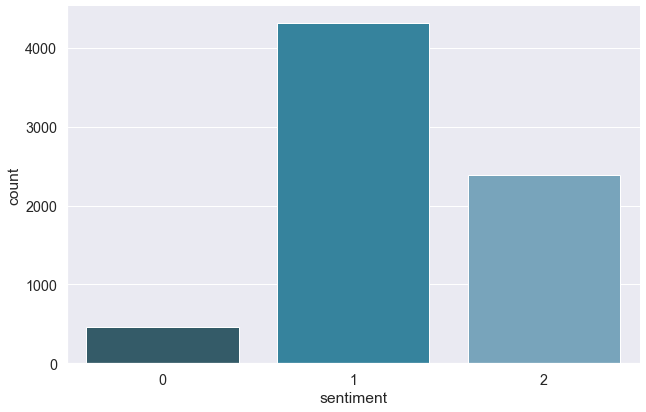

In [768]:
sns.factorplot(x="sentiment", data=df, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

## Text exploration

In [664]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):     
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        pos_family = {
                        'noun' : ['NN','NNS','NNP','NNPS'],
                        'pron' : ['PRP','PRP$','WP','WP$'],
                        'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
                        'adj' :  ['JJ','JJR','JJS'],
                        'adv' : ['RB','RBR','RBS','WRB']
                     }

        # function to check and get the part of speech tag count of a words in a given sentence
        def check_pos_tag(x, flag):
            cnt = 0
            try:
                wiki = textblob.TextBlob(x)
                for tup in wiki.tags:
                    ppo = list(tup)[1]
                    if ppo in pos_family[flag]:
                        cnt += 1
            except:
                pass
            return cnt

        count_noun = X.apply(lambda x: check_pos_tag(x, 'noun'))
        count_verb = X.apply(lambda x: check_pos_tag(x, 'verb'))
        count_adj = X.apply(lambda x: check_pos_tag(x, 'adj'))
        count_adv = X.apply(lambda x: check_pos_tag(x, 'adv'))
        count_pron = X.apply(lambda x: check_pos_tag(x, 'pron'))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                           , 'count_noun' : count_noun
                           , 'count_verb' : count_verb
                           , 'count_adj' : count_adj 
                           , 'count_adv' : count_adv
                           , 'count_pron' : count_pron
                          })
        
        return df
tc = TextCounts()
df_eda = tc.fit_transform(df.tweet)
df_eda['sentiment'] = df.sentiment

In [665]:
df_eda.head(3)

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,count_noun,count_verb,count_adj,count_adv,count_pron,sentiment
5432,21,4,1,4,1,0,0,13,3,0,0,0,2
3049,21,0,2,1,0,0,0,12,4,1,0,0,1
3535,21,2,1,0,0,0,0,11,2,1,1,0,1


In [666]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', size=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
            count       mean       std  min   25%   50%   75%   max
sentiment                                                          
0          456.0   19.500000  5.405736  6.0  16.0  20.0  24.0  32.0
1          4310.0  18.045012  5.223198  2.0  14.0  18.0  22.0  41.0
2          2382.0  18.863980  5.289912  4.0  15.0  19.0  23.0  35.0


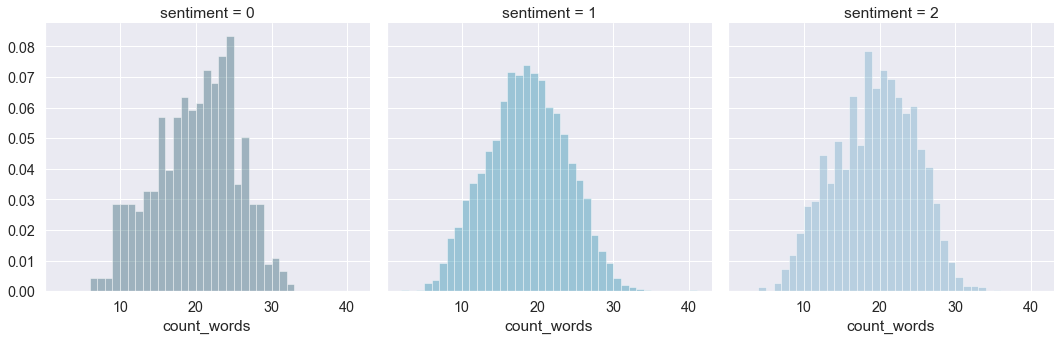

In [667]:
show_dist(df_eda, 'count_words')

Descriptive stats for count_mentions
------------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0          456.0   0.552632  0.739374  0.0  0.0  0.0  1.0  4.0
1          4310.0  0.850348  0.976455  0.0  0.0  1.0  1.0  8.0
2          2382.0  0.740134  0.838025  0.0  0.0  1.0  1.0  5.0


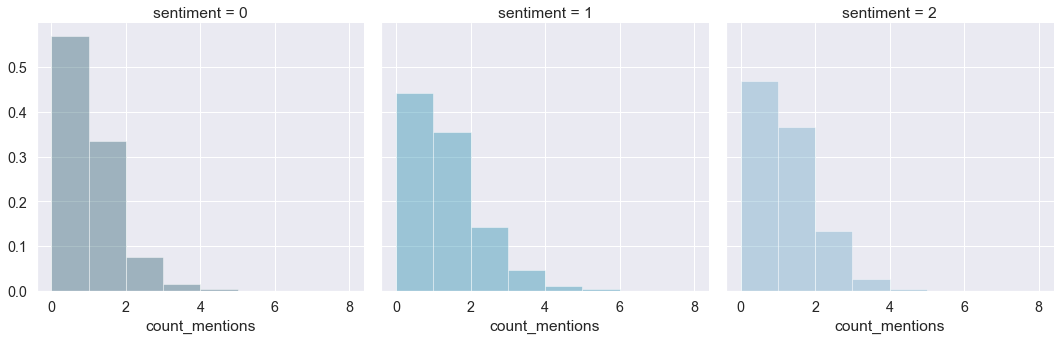

In [668]:
show_dist(df_eda, 'count_mentions')

## Text Cleaning

In [671]:
class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')+['link','quot','amp']
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 2] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [672]:
ct = CleanText()
sr_clean = ct.fit_transform(df.tweet)
sr_clean.sample(5)

1202    art ipad view daili sxsw free coffe idevic recharg austin detail            
1410    sxsw recommend engin session fantast thank googl pandora youtub stumbledupon
1544    umm hello android awesom new version iphon new web site come sxsw           
1420    offici ipad sxsw appl store sxsw other                                      
4354    still wait someon stop new ipad game prize wait sxsw                        
Name: tweet, dtype: object

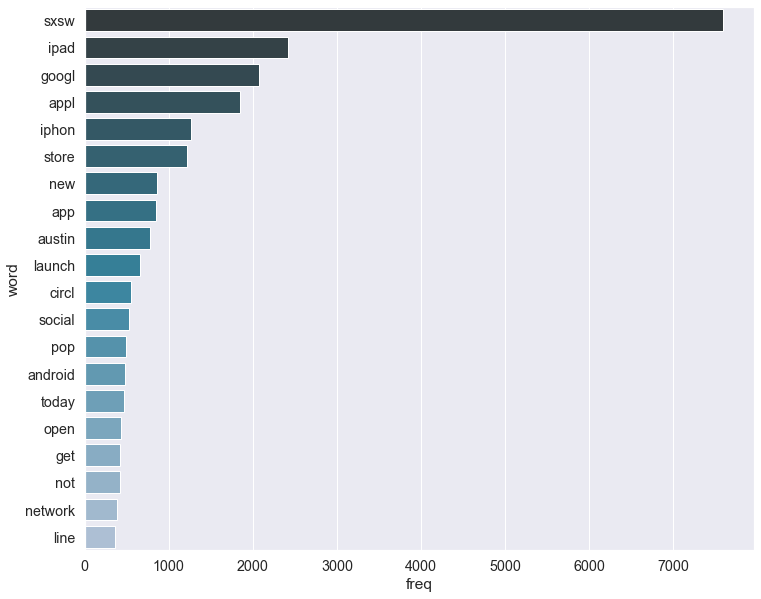

In [673]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="freq", y="word", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [674]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'count_noun',
 'count_verb',
 'count_adj',
 'count_adv',
 'count_pron',
 'sentiment',
 'clean_text']

## Model selection and hyperparamter tuning

In [734]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [735]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('sentiment', axis=1), df_model.sentiment, test_size=0.1, random_state=37)


In [736]:
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags','count_mentions'
                      ,'count_urls','count_words','count_noun','count_verb','count_adj','count_adv','count_pron']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [788]:
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': [1]
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': np.linspace(0.25, 1.5, 6)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.01, 0.1, 0.25, 0.5, 1.0)
}


# Parameter grid settings for ComplementNB
parameters_cnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


# Parameter grid settings for SVM (linear kernel)
parameters_svm = {
    'clf__C': (0.05, 0.1, 0.15, 0.25, 0.5, 0.75, 1, 10)
}


# Parameter grid setting for SVM (rbf kernel)
parameters_svm_rbf = {
    'clf__C': (0.01, 0.1, 1, 10, 15),
    'clf__gamma': (0.1, 1, 10, 100)
}


# Parameter grid settings for Decision Tree
parameters_dt = {
    'clf__max_depth': np.arange(5,25,2),
}


# Parameter grid settings for RF
parameters_rf = {
    'clf__n_estimators': (100, 200),
}


# # Parameter grid setting for XGBoost (Already trained)
# parameters_xgb = {
#      "clf__max_depth": [12]
# }

In [789]:
mnb = MultinomialNB()
logreg = LogisticRegression()
cnb = ComplementNB()
linear_svm = LinearSVC()
rbf_svm = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
# xgb = XGBClassifier(n_estimators=200, objective='multi:softmax', learning_rate=0.05, eval_metric='merror')

## Count Vectorizer

In [790]:
countvect = CountVectorizer()

In [786]:
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': array([0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 ]),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': [1],
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   35.0s finished


done in 37.911s

Best CV score: 0.668
Best parameters set:
	clf__alpha: 0.5
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.716


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.83      0.12      0.22        40
           1       0.74      0.86      0.79       435
           2       0.66      0.56      0.61       240

    accuracy                           0.72       715
   macro avg       0.74      0.51      0.54       715
weighted avg       0.72      0.72      0.70       715



In [495]:
# Logistic Regression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.01, 0.1, 0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  3.6min finished


done in 218.664s

Best CV score: 0.691
Best parameters set:
	clf__C: 0.5
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.678


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.39      0.18      0.25        38
           1       0.71      0.82      0.76       431
           2       0.62      0.50      0.56       246

    accuracy                           0.68       715
   macro avg       0.57      0.50      0.52       715
weighted avg       0.66      0.68      0.66       715



In [336]:
# ComplementNB
best_cnb_countvect = grid_vect(cnb, parameters_cnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   39.2s finished


done in 41.701s

Best CV score: 0.672
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.695


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.46      0.26      0.33        47
           1       0.73      0.82      0.77       443
           2       0.63      0.55      0.59       238

    accuracy                           0.70       728
   macro avg       0.61      0.54      0.56       728
weighted avg       0.68      0.70      0.68       728



In [746]:
# Linear SVM
best_lsvm_countvect = grid_vect(linear_svm, parameters_svm, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.05, 0.1, 0.15, 0.25, 0.5, 0.75, 1, 10),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': [1],
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  6.7min finished


done in 408.836s

Best CV score: 0.691
Best parameters set:
	clf__C: 0.05
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.731


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.50      0.20      0.29        40
           1       0.75      0.88      0.81       435
           2       0.71      0.55      0.62       240

    accuracy                           0.73       715
   macro avg       0.65      0.54      0.57       715
weighted avg       0.72      0.73      0.72       715



In [412]:
# Decision Tree
best_dt_countvect = grid_vect(dt, parameters_dt, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__max_depth': array([ 5,  7,  9, 11, 13, 15, 17, 19, 21, 23]),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.5min finished


done in 151.740s

Best CV score: 0.647
Best parameters set:
	clf__max_depth: 21
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.625


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.50      0.16      0.24        38
           1       0.65      0.87      0.74       431
           2       0.53      0.28      0.36       246

    accuracy                           0.63       715
   macro avg       0.56      0.43      0.45       715
weighted avg       0.60      0.63      0.58       715



In [288]:
# RF
best_rf_countvect = grid_vect(rf, parameters_rf, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__n_estimators': (100, 200),
 'features__pipe__vect__max_df': (0.25, 0.75),
 'features__pipe__vect__min_df': [1],
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.2min finished


done in 317.397s

Best CV score: 0.682
Best parameters set:
	clf__n_estimators: 100
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.730


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.75      0.23      0.35        40
           1       0.72      0.91      0.81       435
           2       0.75      0.48      0.58       240

    accuracy                           0.73       715
   macro avg       0.74      0.54      0.58       715
weighted avg       0.73      0.73      0.71       715



In [304]:
# SVM with rbf kernel
best_rbf_svm_countvect = grid_vect(rbf_svm, parameters_svm_rbf, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.01, 0.1, 1, 10, 15),
 'clf__gamma': (0.1, 1, 10, 100),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2), (2, 3))}
Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 69.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 102.2min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 102.5min finished


done in 6160.041s

Best CV score: 0.661
Best parameters set:
	clf__C: 10
	clf__gamma: 0.1
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.698


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.67      0.20      0.31        40
           1       0.72      0.86      0.78       435
           2       0.64      0.49      0.56       240

    accuracy                           0.70       715
   macro avg       0.68      0.52      0.55       715
weighted avg       0.69      0.70      0.68       715



In [792]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=12,
 min_child_weight=0,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 scale_pos_weight=1,
 seed=27)

In [1]:
# # XGB Classifier
# best_xgb_countvect = grid_vect(xgb1, parameters_xgb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

## TF - IDF

In [529]:
tfidfvect = TfidfVectorizer()

In [346]:
# MultinomialNB
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': array([0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 ]),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.1min finished


done in 69.208s

Best CV score: 0.663
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.688


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.75      0.06      0.12        47
           1       0.71      0.88      0.78       443
           2       0.62      0.46      0.53       238

    accuracy                           0.69       728
   macro avg       0.69      0.47      0.48       728
weighted avg       0.68      0.69      0.66       728



In [600]:
# LogisticRegression
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.01, 0.1, 0.25, 0.5, 1.0),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (0.5, 1),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.5min finished


done in 148.072s

Best CV score: 0.645
Best parameters set:
	clf__C: 1.0
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.646


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.67      0.86      0.75       431
           2       0.57      0.37      0.45       246

    accuracy                           0.65       715
   macro avg       0.41      0.41      0.40       715
weighted avg       0.60      0.65      0.61       715



In [751]:
# Linear SVM
best_lsvm_tfidf = grid_vect(linear_svm, parameters_svm, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.05, 0.1, 0.15, 0.25, 0.5, 0.75, 1, 10),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': [1],
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  7.7min finished


done in 466.707s

Best CV score: 0.688
Best parameters set:
	clf__C: 0.75
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.722


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.53      0.20      0.29        40
           1       0.75      0.85      0.80       435
           2       0.67      0.57      0.62       240

    accuracy                           0.72       715
   macro avg       0.65      0.54      0.57       715
weighted avg       0.71      0.72      0.71       715



## word2vec

In [396]:
SIZE = 25

X_train['clean_text_wordlist'] = X_train.clean_text.apply(lambda x : word_tokenize(x))
X_test['clean_text_wordlist'] = X_test.clean_text.apply(lambda x : word_tokenize(x))

model = gensim.models.Word2Vec(X_train.clean_text_wordlist, min_count=1, size=SIZE, window=3, workers=4)

In [699]:
model.most_similar('network', topn=5)

[('circl', 0.9991441965103149),
 ('call', 0.9987877607345581),
 ('social', 0.9986657500267029),
 ('major', 0.9986647367477417),
 ('possibl', 0.9984349012374878)]

In [403]:
def compute_avg_w2v_vector(w2v_dict, tweet):
    list_of_word_vectors = [w2v_dict[w] for w in tweet if w in w2v_dict.vocab.keys()]
    
    if len(list_of_word_vectors) == 0:
        result = [0.0]*SIZE
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return result

In [404]:
X_train_w2v = X_train['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))
X_test_w2v = X_test['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))

In [405]:
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)

# Concatenate with the TextCounts variables
X_train_w2v = pd.concat([X_train_w2v, X_train.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_test_w2v = pd.concat([X_test_w2v, X_test.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)

In [406]:
# Logistic Regression
best_logreg_w2v = grid_vect(logreg, parameters_logreg, X_train_w2v, X_test_w2v, is_w2v=True)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.2s finished


done in 8.582s

Best CV score: 0.602
Best parameters set:
	clf__C: 0.5
	clf__penalty: 'l2'
Test score with best_estimator_: 0.618


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.63      0.90      0.74       431
           2       0.53      0.22      0.31       246

    accuracy                           0.62       715
   macro avg       0.39      0.37      0.35       715
weighted avg       0.56      0.62      0.55       715



In [407]:
# Linear SVM
best_lsvm_w2v = grid_vect(linear_svm, parameters_svm, X_train_w2v, X_test_w2v, is_w2v=True)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.1, 0.15, 0.25, 0.75, 1)}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   54.1s finished


done in 59.664s

Best CV score: 0.606
Best parameters set:
	clf__C: 0.15
Test score with best_estimator_: 0.620


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.63      0.92      0.75       431
           2       0.54      0.19      0.28       246

    accuracy                           0.62       715
   macro avg       0.39      0.37      0.34       715
weighted avg       0.57      0.62      0.55       715



## Training on best model

In [752]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags','count_mentions'
                      ,'count_urls','count_words','count_noun','count_verb','count_adj','count_adv','count_pron']
    
features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                         , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
                                              , ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))]
                       , n_jobs=-1)

pipeline = Pipeline([
    ('features', features)
    , ('clf', LinearSVC(C=0.05, penalty='l2'))
])


best_model = pipeline.fit(df_model.drop('sentiment', axis=1), df_model.sentiment)

# Test Set

In [753]:
test_df = pd.read_csv('test.csv')
ids = test_df['tweet_id']

In [754]:
tweets = test_df['tweet']
df_counts_test = tc.transform(tweets)
df_clean_test = ct.transform(tweets)
df_model_test = df_counts_test
df_model_test['clean_text'] = df_clean_test

In [755]:
df_model_test.shape

(1819, 13)

In [760]:
preds = best_model.predict(df_model_test)

In [761]:
submit_df = pd.concat([ids, pd.Series(preds)], axis=1)
submit_df.columns = ['tweet_id', 'sentiment']
submit_df

,tweet_id,sentiment
0,7506,1
1,7992,1
2,247,2
3,7688,2
4,3294,2
...,...,...
1814,1550,2
1815,1933,1
1816,9052,2
1817,4219,2


In [762]:
submit_df.to_csv('submission_superduper_final.csv', index=False)
submit_df

,tweet_id,sentiment
0,7506,1
1,7992,1
2,247,2
3,7688,2
4,3294,2
...,...,...
1814,1550,2
1815,1933,1
1816,9052,2
1817,4219,2


In [759]:
submit_df['sentiment'].value_counts(normalize=True)

1    0.709181
2    0.266080
0    0.024739
Name: sentiment, dtype: float64

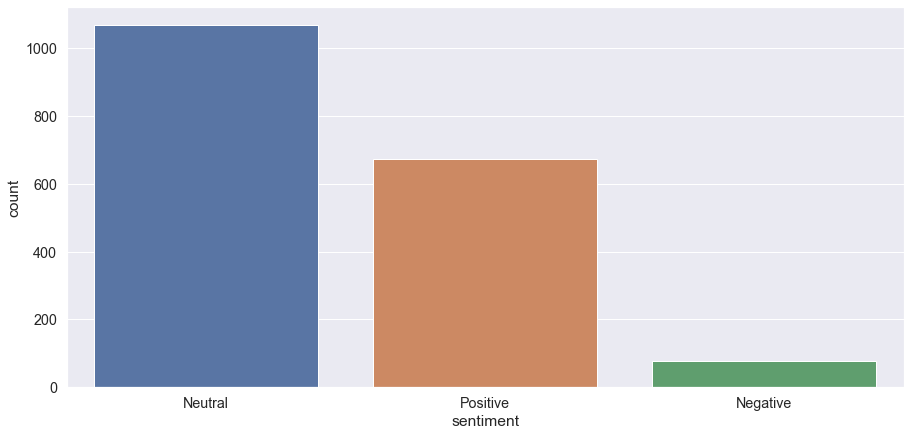

In [763]:
plt.figure(figsize=(15,7))
submit_df['sentiment'] = submit_df['sentiment'].map({0:'Negative', 1:'Neutral', 2:'Positive'})
sns.countplot(submit_df['sentiment'])